# Comparison of classifiers

Import all the packages that we need

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

from matplotlib import pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale

%matplotlib inline
plt.style.use('ggplot') # emulate pretty r-style plots

np.set_printoptions(precision=4) #print numpy arrays with precision 4

Read the data from Weekly.csv. The data set Weekly contains 1089 weekly returns of a stock index for 21 years, from the beginning of 1990 to the end of 2010. Lags refer to the percentage returns for each of the five previous periods.

In [4]:
df = pd.read_csv('./Data/Weekly.csv')
print('Weekly dataframe shape =', df.shape)
df.head()

Weekly dataframe shape = (1089, 9)


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


We are interested in the relationship between each of the predictors (lags and volume) with the market direction. 

a) Compute the matrix of correlations between the variables and comment on the output and on what to expect from regression models.

In [6]:
correlations = df.corr(method='pearson', numeric_only=True)
print(correlations)

            Year      Lag1      Lag2      Lag3      Lag4      Lag5    Volume  \
Year    1.000000 -0.032289 -0.033390 -0.030006 -0.031128 -0.030519  0.841942   
Lag1   -0.032289  1.000000 -0.074853  0.058636 -0.071274 -0.008183 -0.064951   
Lag2   -0.033390 -0.074853  1.000000 -0.075721  0.058382 -0.072499 -0.085513   
Lag3   -0.030006  0.058636 -0.075721  1.000000 -0.075396  0.060657 -0.069288   
Lag4   -0.031128 -0.071274  0.058382 -0.075396  1.000000 -0.075675 -0.061075   
Lag5   -0.030519 -0.008183 -0.072499  0.060657 -0.075675  1.000000 -0.058517   
Volume  0.841942 -0.064951 -0.085513 -0.069288 -0.061075 -0.058517  1.000000   
Today  -0.032460 -0.075032  0.059167 -0.071244 -0.007826  0.011013 -0.033078   

           Today  
Year   -0.032460  
Lag1   -0.075032  
Lag2    0.059167  
Lag3   -0.071244  
Lag4   -0.007826  
Lag5    0.011013  
Volume -0.033078  
Today   1.000000  


b) Plot the correlation between year and volume, today's return and lag1 and today's return and lag2.

Text(0, 0.5, "Today's return")

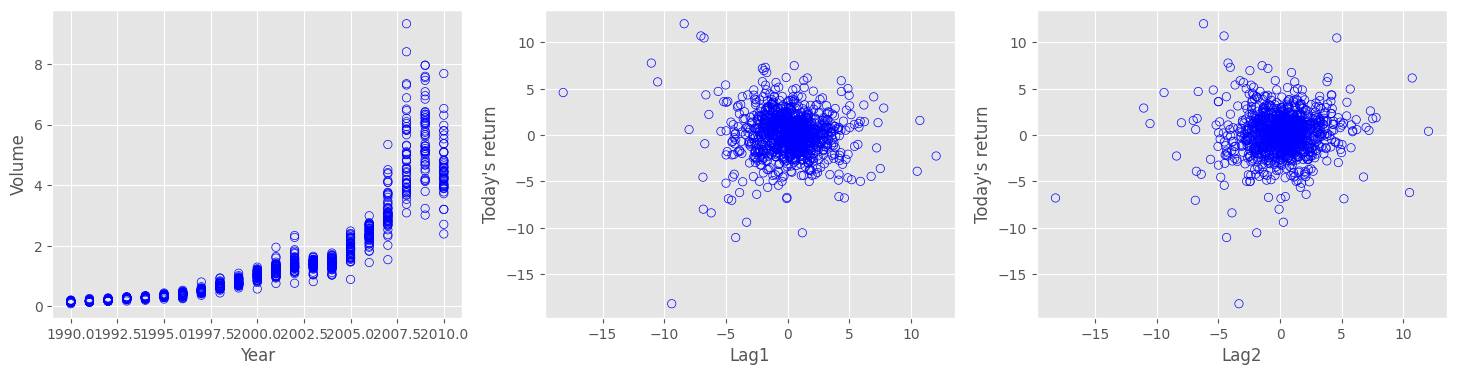

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))
ax1.scatter(df.Year.values, df.Volume, facecolor = 'none', edgecolor = 'b')
ax1.set_xlabel('Year')
ax1.set_ylabel('Volume')

ax2.scatter(df.Lag1.values, df.Today, facecolor = 'none', edgecolor = 'b')
ax2.set_xlabel('Lag1')
ax2.set_ylabel('Today\'s return')

ax3.scatter(df.Lag2.values, df.Today, facecolor = 'none', edgecolor = 'b')
ax3.set_xlabel('Lag2')
ax3.set_ylabel('Today\'s return')

c) Perform a logistic regression with the market direction as response and all the lags and volume as predictors. To do this you need to convert the direction into a binary value ('up'=1 and 'down'=0). Comment on the output.

In [11]:
X = sm.add_constant(df[df.columns[1:7]])
y = np.array([1 if direction=='Up' else 0 for direction in df.Direction.values])

logit = sm.Logit(y,X)
results = logit.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Thu, 22 May 2025   Pseudo R-squ.:                0.006580
Time:                        15:21:47   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.

d) Predict the results for the full data set and compute the confusion matrix. Comment on the confusion matrix.

In [15]:
y_predicted = results.predict(X)
y_predicted = np.array(y_predicted > 0.5, dtype=float)

table = np.histogram2d(y_predicted, y, bins=2)[0]
print(table)

print('Confusion matrix')
print(pd.DataFrame(table, ['Down', 'Up'], ['Down', 'Up']))
print('\n')
print('Error rate=', 1-(table[0,0]+table[1,1])/np.sum(table))

[[ 54.  48.]
 [430. 557.]]
Confusion matrix
       Down     Up
Down   54.0   48.0
Up    430.0  557.0


Error rate= 0.43893480257116624


e) Split the data set into a training and a test set. The training data will be the data drom the years 1990 through 2008 and the testing data will be from 2009 through 2010. Refit the logistic regression from task c) using 'Lag2' as the only predictor. Predict the results for the test set and build the confusion matrix. Comment on the confusion matrix.

In [20]:
# Training-Set:
X_train = sm.add_constant(df[df.Year <= 2008].Lag2)
response_train = df[df.Year <= 2008].Direction
y_train = np.array([1 if el=='Up' else 0 for el in response_train])
# Test-Set:
X_test = sm.add_constant(df[df.Year > 2008].Lag2)
response_test = df[df.Year > 2008].Direction
y_test = np.array([1 if el=='Up' else 0 for el in response_test])

logit = sm.Logit(y_train, X_train)
results = logit.fit()
print(results.summary())
print('\n')

y_predicted = results.predict(X_test)
y_predicted = np.array(y_predicted > 0.5, dtype=float)

table = np.histogram2d(y_predicted, y_test, bins=2)[0]
print(table)

print('Confusion matrix')
print(pd.DataFrame(table, ['Down', 'Up'], ['Down', 'Up']))
print('\n')
print('Error rate=', 1-(table[0,0]+table[1,1])/np.sum(table))

Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  985
Model:                          Logit   Df Residuals:                      983
Method:                           MLE   Df Model:                            1
Date:                Thu, 22 May 2025   Pseudo R-squ.:                0.003076
Time:                        17:42:28   Log-Likelihood:                -675.27
converged:                       True   LL-Null:                       -677.35
Covariance Type:            nonrobust   LLR p-value:                   0.04123
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2033      0.064      3.162      0.002       0.077       0.329
Lag2           0.0581      0.

f) Predict the market direction using the linear discriminant analysis, again only with 'lag2' as predictor and the same training and test set as in task e). Print the priors P('Up') and P('Down') and the class means $\mu_{Up}$ and $\mu_{Down}$ and the variances (remember the variance is assumed to be the same for all classes in LDA). Predict the results for the test set and build the confusion matrix. Comment on the confusion matrix.

In [24]:
# Create classifier
clf = LDA(solver = 'lsqr', store_covariance=True)

X_train = df[df.Year <= 2008].Lag2.values
X_train = X_train.reshape((len(X_train), 1))

X_test = df[df.Year > 2008].Lag2.values
X_test = X_test.reshape((len(X_test), 1))

clf.fit(X_train, y_train)
print('Priors = ', clf.priors_)
print('Class means = ', clf.means_[0], clf.means_[1])
print('Variance = ', clf.covariance_)
print('\n')

y_predicted = clf.predict(X_test)
y_predicted = np.array(y_predicted > 0.5, dtype=float)

table = np.histogram2d(y_predicted, y_test, bins=2)[0]
print(table)

print('Confusion matrix')
print(pd.DataFrame(table, ['Down', 'Up'], ['Down', 'Up']))
print('\n')
print('Error rate=', 1-(table[0,0]+table[1,1])/np.sum(table))

Priors =  [0.4477 0.5523]
Class means =  [-0.0357] [0.2604]
Variance =  [[5.1218]]


[[ 9.  5.]
 [34. 56.]]
Confusion matrix
      Down    Up
Down   9.0   5.0
Up    34.0  56.0


Error rate= 0.375


g) Predict the market direction using the quadratic discriminant analysis, again only with 'lag2' as predictor and the same training and test set as in task e). Print the priors P('Up') and P('Down') and the class means $\mu_{Up}$ and $\mu_{Down}$ and the variances. Predict the results for the test set and build the confusion matrix. Comment on the confusion matrix.

In [29]:
clf = QDA(store_covariance=True)

clf.fit(X_train, y_train)
print('Priors = ', clf.priors_)
print('Class means = ', clf.means_[0], clf.means_[1])
print('Variance = ', clf.covariance_)
print('\n')

y_predicted = clf.predict(X_test)
y_predicted = np.array(y_predicted > 0.5, dtype=float)

table = np.histogram2d(y_predicted, y_test, bins=2)[0]
print(table)

print('Confusion matrix')
print(pd.DataFrame(table, ['Down', 'Up'], ['Down', 'Up']))
print('\n')
print('Error rate=', 1-(table[0,0]+table[1,1])/np.sum(table))

Priors =  [0.4477 0.5523]
Class means =  [-0.0357] [0.2604]
Variance =  [array([[4.8378]]), array([[5.3707]])]


[[ 0.  0.]
 [43. 61.]]
Confusion matrix
      Down    Up
Down   0.0   0.0
Up    43.0  61.0


Error rate= 0.41346153846153844


h) Predict the market direction using the $k$-nearest neighbor analysis, again only with 'lag2' as predictor and the same training and test set as in task e). Try to experiment with different values for $k$.Predict the results for the test set and build the confusion matrix. Comment on the confusion matrix.

In [38]:
clf = KNeighborsClassifier(n_neighbors=20)
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)

table = np.histogram2d(y_predicted, y_test, bins=2)[0]
# print(table)

print('Confusion matrix')
print(pd.DataFrame(table, ['Down', 'Up'], ['Down', 'Up']))
print('\n')
print('Error rate=', 1-(table[0,0]+table[1,1])/np.sum(table))

Confusion matrix
      Down    Up
Down  23.0  22.0
Up    20.0  39.0


Error rate= 0.40384615384615385


i) Predict the market direction using a logistic regression again, but this time using 'lag1', 'lag2' and 'lag3' as predictors and the same training and test set as in task e). Predict the results for the test set and build the confusion matrix. Comment on the confusion matrix.

In [41]:
predictors = df.columns[1:4]
X_train = sm.add_constant(df[df.Year <= 2008][predictors])
response_train = df[df.Year <= 2008].Direction
y_train = np.array([1 if el=='Up' else 0 for el in response_train])

X_test = sm.add_constant(df[df.Year > 2008][predictors])
response_test = df[df.Year > 2008].Direction
y_test = np.array([1 if el=='Up' else 0 for el in response_test])

logit = sm.Logit(y_train, X_train)
results = logit.fit()
print(results.summary())
print('\n')

y_predicted = results.predict(X_test)
y_predicted = np.array(y_predicted > 0.5, dtype=float)

table = np.histogram2d(y_predicted, y_test, bins=2)[0]
# print(table)

print('Confusion matrix')
print(pd.DataFrame(table, ['Down', 'Up'], ['Down', 'Up']))
print('\n')
print('Error rate=', 1-(table[0,0]+table[1,1])/np.sum(table))

Optimization terminated successfully.
         Current function value: 0.683687
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  985
Model:                          Logit   Df Residuals:                      981
Method:                           MLE   Df Model:                            3
Date:                Thu, 22 May 2025   Pseudo R-squ.:                0.005792
Time:                        18:07:17   Log-Likelihood:                -673.43
converged:                       True   LL-Null:                       -677.35
Covariance Type:            nonrobust   LLR p-value:                   0.04928
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2123      0.065      3.282      0.001       0.086       0.339
Lag1          -0.0537      0.

j) Predict the market direction using a logistic regression again, but this time using 'lag1', 'lag2' and the interaction between 'lag1' and 'lag2' as predictors and the same training and test set as in task e). Predict the results for the test set and build the confusion matrix. Comment on the confusion matrix.

In [43]:
df['Lag1*Lag2'] = pd.Series(df.Lag1*df.Lag2, index=df.index)

predictors = ['Lag1', 'Lag2', 'Lag1*Lag2']
X_train = sm.add_constant(df[df.Year <= 2008][predictors])
response_train = df[df.Year <= 2008].Direction
y_train = np.array([1 if el=='Up' else 0 for el in response_train])

X_test = sm.add_constant(df[df.Year > 2008][predictors])
response_test = df[df.Year > 2008].Direction
y_test = np.array([1 if el=='Up' else 0 for el in response_test])

logit = sm.Logit(y_train, X_train)
results = logit.fit()
print(results.summary())
print('\n')

y_predicted = results.predict(X_test)
y_predicted = np.array(y_predicted > 0.5, dtype=float)

table = np.histogram2d(y_predicted, y_test, bins=2)[0]
# print(table)

print('Confusion matrix')
print(pd.DataFrame(table, ['Down', 'Up'], ['Down', 'Up']))
print('\n')
print('Error rate=', 1-(table[0,0]+table[1,1])/np.sum(table))

Optimization terminated successfully.
         Current function value: 0.683701
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  985
Model:                          Logit   Df Residuals:                      981
Method:                           MLE   Df Model:                            3
Date:                Thu, 22 May 2025   Pseudo R-squ.:                0.005772
Time:                        18:10:22   Log-Likelihood:                -673.45
converged:                       True   LL-Null:                       -677.35
Covariance Type:            nonrobust   LLR p-value:                   0.04990
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2114      0.065      3.273      0.001       0.085       0.338
Lag1          -0.0515      0.

No improvements. Error rate still 42%. Confusion matrix: Lag1 still a bad predictor. Best results obtained from only using Lag2 as a predictor (see Task h))